In this notebook we use the [Covertype Data Set](http://archive.ics.uci.edu/ml/datasets/Covertype), a dataset describing cartographic 
features of areas of land in the USA and also its forest type according to the US Forest Service. 
There are seven classes (1-7), 581012 samples and 54 features.
For this analysis, we're only interested in cover type 3.




In [1]:
import numpy as np
import sklearn.datasets
import sklearn.linear_model
import sklearn.metrics

In [2]:
np.random.seed(42)  # do not change for reproducibility

In [3]:
dataset = sklearn.datasets.fetch_covtype()

In [4]:
# only use a random subset for speed - pretend the rest of the data doesn't exist
random_sample = np.random.choice(len(dataset.data), len(dataset.data) // 10)

COVER_TYPE = 3
features = dataset.data[random_sample, :]
target = dataset.target[random_sample] == COVER_TYPE

## Summary of the main results

Here is a summary of the main results:
- **Section 1: logistic regression as baseline model**
    - Due to the unbalanced nature of the data, it is recommended to also use the "Balanced Accuracy Score" and the "F1 Score" to evaluate the performance of the model.
- **Section 2: should we get more training data?**
    - Simply adding more data into the model training does not help.
    - Using random under-sampling for the majority class (the non type 3 class) solves the data imbalance issue. 
- **Section 3: how to decide what feature to include in the deployed model?**
    - Random forest is used to find out the 17 most import features.
    - Using these 17 features for model training reduces the overall training time, and also maintains the model's performance.
    
For details please refer to the following analysis.

## Analysis

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

### Preprocessing

In [6]:
## convert dataset.data into a pandas dataframe data_df
data_df = pd.DataFrame(dataset.data, columns = dataset.feature_names)
data_df.columns = data_df.columns.str.lower()
data_df.rename(columns={"horizontal_distance_to_hydrology": "hd_hydrology",
                        "vertical_distance_to_hydrology": "vd_hydrology",
                        "horizontal_distance_to_roadways": "hd_hydrology",
                        "horizontal_distance_to_fire_points": "hd_fire_points"},
              inplace=True)

## convert dataset.target into a pandas dataframe target_df
target_df = pd.DataFrame(dataset.target, columns=dataset.target_names)
target_df.columns=target_df.columns.str.lower()

In [7]:
## take a look at the data
data_df.describe()

,elevation,aspect,slope,hd_hydrology,vd_hydrology,hd_hydrology,hillshade_9am,hillshade_noon,hillshade_3pm,hd_fire_points,...,soil_type_30,soil_type_31,soil_type_32,soil_type_33,soil_type_34,soil_type_35,soil_type_36,soil_type_37,soil_type_38,soil_type_39
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: cover_type, dtype: int64

Cover type percentage:
2    48.759922
1    36.460521
3     6.153746
7     3.530048
6     2.989095
5     1.633873
4     0.472796
Name: cover_type, dtype: float64


<AxesSubplot:ylabel='cover_type'>

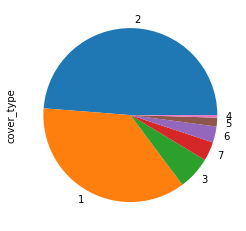

In [8]:
## Portion of the cover types in the whole dataset

print(target_df["cover_type"].value_counts())
type_percent_series = target_df["cover_type"].value_counts()/target_df["cover_type"].count() * 100
print("\nCover type percentage:")
print(type_percent_series)
target_df["cover_type"].value_counts().plot.pie()

The above analysis shows that the cover_type data is extremely imbalanced. In this test we are only interested in type 3, which is only of 6% of the data.

In [9]:
## Portion of the cover types in the random subset

count_true = (target==True).sum()
count_false = (target==False).sum()
print(f"Total number of records in the random subset: {len(target)}, \
      \nnumber of type 3 records: {count_true}, \
      \nnumber of other type records: {count_false}.")
type3_perc = 100 * count_true / len(target)
print(f"\nPercentage of type 3 records: {type3_perc:.1f}%")

Total number of records in the random subset: 58101,       
number of type 3 records: 3541,       
number of other type records: 54560.

Percentage of type 3 records: 6.1%


In [10]:
## create the training set and test set with train_test_split

sub_feature_train, sub_feature_test, sub_target_train, sub_target_test = train_test_split(features, target, 
                                                                                          test_size=0.3, random_state=42)

In [11]:
## helper function for corss validation

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    
def perform_cross_validations(classifier, X_train, y_train):
    accuracy_scores_sub = cross_val_score(classifier, X_train, y_train, scoring="accuracy", cv=10)
    balanced_accuracy_scores_sub = cross_val_score(classifier, X_train, y_train, scoring="balanced_accuracy", cv=10)
    f1_scores_sub = cross_val_score(classifier, X_train, y_train, scoring="f1", cv=10)
    
    score_dict = {
        "accuracy_mean": [accuracy_scores_sub.mean()],
        "accuracy_std": [accuracy_scores_sub.std()],
        "balanced_accuracy_mean": [balanced_accuracy_scores_sub.mean()],
        "balanced_accuracy_std": [balanced_accuracy_scores_sub.std()],
        "f1_mean": [f1_scores_sub.mean()],
        "f1_std": [f1_scores_sub.std()]
    }
    
    score_df = pd.DataFrame.from_dict(score_dict)
    
    print("\nCross validation: accuracy")
    display_scores(accuracy_scores_sub)
    
    print("\nCross validation: balanced_accuracy")
    display_scores(balanced_accuracy_scores_sub)
    
    print("\nCross validation: f1")
    display_scores(f1_scores_sub)
    
    return score_df
    
def evaluate_with_test_data(y_predict, y_test):
    
    accuracy_scores_sub = sklearn.metrics.accuracy_score(y_predict, y_test)
    balanced_accuracy_scores_sub = sklearn.metrics.balanced_accuracy_score(y_predict, y_test)
    f1_scores_sub = sklearn.metrics.f1_score(y_predict, y_test)
    
    print(f"\nAccuracy: {accuracy_scores_sub:.3f}")
    
    print(f"\nBalanced accuracy: {balanced_accuracy_scores_sub:.3f}")
    
    print(f"\nF1: {f1_scores_sub:.3f}")

### Section 1: logistic regression as baseline model

In [12]:
classifier = sklearn.linear_model.LogisticRegression(solver='liblinear') # do not change this

In [13]:
## use cross validation to evaluate the classifier's performance
## different scoring matrics were used: accuracy, balanced_accuracy, and f1

orig_score_df = perform_cross_validations(classifier, sub_feature_train, sub_target_train)


Cross validation: accuracy
Scores: [0.96090484 0.9628719  0.95721662 0.96483895 0.9641013  0.96311778
 0.96164249 0.95942955 0.96360954 0.96336366]
Mean: 0.9621096631423655
Standard deviation: 0.0022277730990898892

Cross validation: balanced_accuracy
Scores: [0.78902748 0.79768098 0.77755632 0.83485945 0.82115523 0.82443514
 0.82106227 0.78932496 0.81064887 0.81815803]
Mean: 0.8083908735253995
Standard deviation: 0.017849132373127533

Cross validation: f1
Scores: [0.64745011 0.66518847 0.61842105 0.7027027  0.6893617  0.68619247
 0.675      0.63894967 0.67826087 0.68230277]
Mean: 0.6683829820205108
Standard deviation: 0.024659987871335776


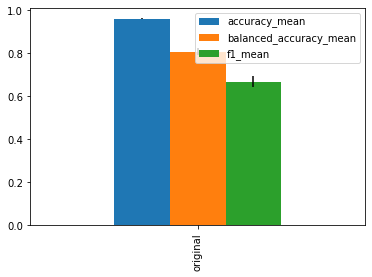

In [14]:
orig_score_df.rename(index={0:"original"}, inplace=True)
orig_score_df[["accuracy_mean", 
               "balanced_accuracy_mean", 
               "f1_mean"]].plot(kind="bar",yerr=orig_score_df[["accuracy_std", 
                                                              "balanced_accuracy_std", 
                                                              "f1_std"]].values.T)
plt.show()

In [15]:
classifier.fit(sub_feature_train,  sub_target_train)
y_predict = classifier.predict(sub_feature_test)
evaluate_with_test_data(y_predict, sub_target_test)


Accuracy: 0.960

Balanced accuracy: 0.837

F1: 0.666


### Section 2: should we get more training data?

***Approach 1: simply involve more data***

I first try to involve more data in the cross validation and see if the performance improves with regard to accuracy, balanced accuray, and f1 scores.

In [16]:
## add column "is_type3" in target_df
target_df["is_type3"]=(target_df["cover_type"]==3).astype(int)

In [17]:
## create the training set and test set with train_test_split

data_train, data_test, target_train, target_test = train_test_split(data_df, target_df["is_type3"], test_size=0.3, random_state=42)

In [18]:
## use corss validation to evaluate the classifier's performance
## different scoring matrics were used: accuracy, balanced_accuracy, and f1

more_data_score_df = perform_cross_validations(classifier, data_train, target_train)


Cross validation: accuracy
Scores: [0.96063534 0.96093039 0.96179096 0.96078287 0.96041405 0.96120086
 0.96302033 0.96243023 0.96051143 0.96328989]
Mean: 0.9615006363289019
Standard deviation: 0.001014766759107972

Cross validation: balanced_accuracy
Scores: [0.79783796 0.80134357 0.81005917 0.81026571 0.78942965 0.80788528
 0.82373023 0.8267627  0.80539908 0.82808609]
Mean: 0.810079943307659
Standard deviation: 0.012117149273940085

Cross validation: f1
Scores: [0.65754011 0.66184295 0.67311737 0.66791589 0.64969539 0.66834805
 0.6895128  0.68841762 0.66274675 0.69386918]
Mean: 0.6713006090246179
Standard deviation: 0.014057894570823641


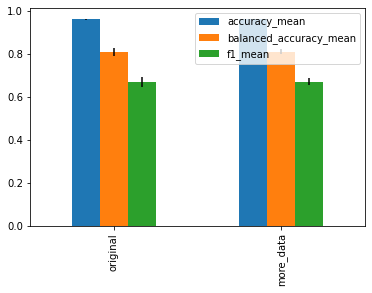

In [19]:
more_data_score_df.rename(index={0:"more_data"}, inplace=True)

all_score_df = pd.concat([orig_score_df, more_data_score_df])

all_score_df[["accuracy_mean", 
               "balanced_accuracy_mean", 
               "f1_mean"]].plot(kind="bar",yerr=all_score_df[["accuracy_std", 
                                                              "balanced_accuracy_std", 
                                                              "f1_std"]].values.T)
plt.show()

The result clearly shows that involving more data into the model training won't improve the model's performance. Therefore, I will try the 2nd approach by getting rid of the impact of the data imbalance.

***Approach 2: take care of the data imbalance issue by under-sampling the majority data***

The following results show that with balanced data, the model's performance has been significantly improved!

In [20]:
from imblearn.under_sampling import RandomUnderSampler

In [21]:
## under sample data_df and target_df

under_sampler = RandomUnderSampler(random_state=42)
data_under_sample, target_under_sample = under_sampler.fit_resample(data_df, target_df["is_type3"])

In [22]:
## check the sahpe

print("data_under_sample.shape: ", data_under_sample.shape, "\ntarget_under_sample.shape: ", target_under_sample.shape)

data_under_sample.shape:  (71508, 54) 
target_under_sample.shape:  (71508,)


In [23]:
## create the training set and test set with train_test_split

us_data_train, us_data_test, us_target_train, us_target_test = train_test_split(data_under_sample, target_under_sample, 
                                                                                test_size=0.3, random_state=42)

In [24]:
## use corss validation to evaluate the classifier's performance
## different scoring matrics were used: accuracy, balanced_accuracy, and f1

balanced_data_score_df = perform_cross_validations(classifier, us_data_train, us_target_train)


Cross validation: accuracy
Scores: [0.9572513  0.95904914 0.96444267 0.95904914 0.96144626 0.95844156
 0.95984016 0.96063936 0.95784216 0.96203796]
Mean: 0.9600039712584658
Standard deviation: 0.0020703888075486077

Cross validation: balanced_accuracy
Scores: [0.95722251 0.95901915 0.96441484 0.95902011 0.96141101 0.95841018
 0.95981186 0.96060882 0.95781956 0.96201397]
Mean: 0.9599752024576599
Standard deviation: 0.0020701778997841767

Cross validation: f1
Scores: [0.95830086 0.96009344 0.96528861 0.96006234 0.96258965 0.95940671
 0.96068844 0.96153095 0.9588132  0.96296296]
Mean: 0.9609737163603892
Standard deviation: 0.0020359658222299827


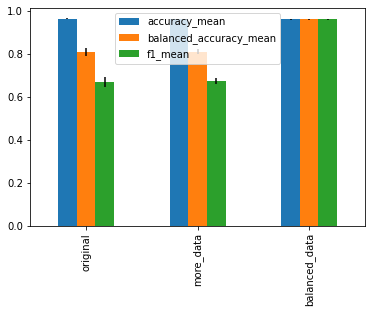

In [25]:
balanced_data_score_df.rename(index={0:"balanced_data"}, inplace=True)

all_score_df = pd.concat([orig_score_df, more_data_score_df, balanced_data_score_df])

all_score_df[["accuracy_mean", 
               "balanced_accuracy_mean", 
               "f1_mean"]].plot(kind="bar",yerr=all_score_df[["accuracy_std", 
                                                              "balanced_accuracy_std", 
                                                              "f1_std"]].values.T)
plt.show()

In [26]:
## retrain the classifier with balanced data and evaluate its performance

balanced_classifier = sklearn.linear_model.LogisticRegression(solver='liblinear')

balanced_classifier.fit(us_data_train, us_target_train)
balanced_training_predictions = balanced_classifier.predict(us_data_test)

evaluate_with_test_data(balanced_training_predictions, us_target_test)


Accuracy: 0.961

Balanced accuracy: 0.962

F1: 0.962


### Section 3: how to decide what feature to include in the deployed model?

Decision tree or random forest are usually used to determine feature importance. Here we use random forest.

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
forest_clf = RandomForestClassifier()
forest_clf.fit(us_data_train, us_target_train)

RandomForestClassifier()

In [29]:
# plt.rcParams['figure.figsize'] = (20, 10)
# plt.rcParams.update({'font.size': 22})

In [30]:
feature_names = us_data_train.columns.values.tolist()

importance = forest_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_clf.estimators_], axis=0)

forest_importance = pd.Series(importance, index=feature_names)

In [31]:
## helper function for printing feature importance

def print_importance_data(col_names, feature_importances):
    fi = sorted(zip(col_names, feature_importances),
        key=(lambda x: x[1]), reverse=True)
    for i, feature_importance in enumerate(fi[:17]):
        feature, importance = feature_importance
        print('{}. {}:\t{}'.format(i + 1, feature.ljust(17), importance))

    print("Contribution of the 17 most important features:",
        sum([x[1] for x in fi[:17]]))

In [32]:
## print the top 17 important features

print_importance_data(feature_names, forest_importance)

1. elevation        :	0.3517319822925128
2. wilderness_area_3:	0.09843350213852846
3. hd_hydrology     :	0.08109791641911156
4. wilderness_area_0:	0.07869343514439661
5. hd_fire_points   :	0.0727649619640313
6. soil_type_3      :	0.04746346099314257
7. soil_type_1      :	0.03322749231977631
8. slope            :	0.025140345492296035
9. soil_type_9      :	0.020147229901754847
10. aspect           :	0.018391124313747002
11. wilderness_area_2:	0.017954575289293787
12. hillshade_9am    :	0.01720531761819654
13. hd_hydrology     :	0.014618381025304626
14. hillshade_noon   :	0.014582366763863189
15. soil_type_28     :	0.014127393470029784
16. vd_hydrology     :	0.013362824327066819
17. hillshade_3pm    :	0.012812208699857322
Contribution of the 17 most important features: 0.9317545181729096


In [33]:
essential_features = [
    "elevation",
    "wilderness_area_3",
    "wilderness_area_0",
    "hd_hydrology",
    "hd_fire_points",
    "soil_type_3",
    "soil_type_1",
    "slope",
    "wilderness_area_2",
    "soil_type_9",
    "hillshade_9am",
    "aspect",
    "soil_type_28",
    "hillshade_noon",
    "hd_hydrology",
    "hillshade_3pm",
    "vd_hydrology"
]

In [34]:
## use corss validation to evaluate the classifier's performance
## different scoring matrics were used: accuracy, balanced_accuracy, and f1

essential_data_score_df = perform_cross_validations(classifier, us_data_train[essential_features], us_target_train)


Cross validation: accuracy
Scores: [0.95545346 0.95285657 0.95904914 0.95565322 0.95685178 0.95644356
 0.95604396 0.95544456 0.95564436 0.95844156]
Mean: 0.9561882145022377
Standard deviation: 0.001629832250152669

Cross validation: balanced_accuracy
Scores: [0.95543113 0.95283352 0.95902251 0.95562682 0.9568182  0.95641273
 0.9560204  0.95542686 0.95562834 0.95841876]
Mean: 0.9561639261756957
Standard deviation: 0.0016282979932234658

Cross validation: f1
Scores: [0.95631734 0.95379796 0.95998438 0.95665756 0.95807453 0.9574385
 0.95682889 0.95605911 0.95638507 0.95940671]
Mean: 0.9570950055430825
Standard deviation: 0.0016758426535843586


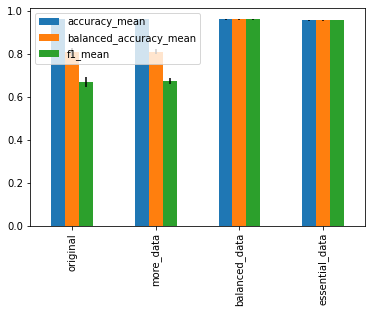

In [35]:
essential_data_score_df.rename(index={0:"essential_data"}, inplace=True)

all_score_df = pd.concat([orig_score_df, more_data_score_df, balanced_data_score_df, essential_data_score_df])

all_score_df[["accuracy_mean", 
               "balanced_accuracy_mean", 
               "f1_mean"]].plot(kind="bar",yerr=all_score_df[["accuracy_std", 
                                                              "balanced_accuracy_std", 
                                                              "f1_std"]].values.T)
plt.show()